### Install dependencies if required

The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true). Running the cell could take some time due to the installation of one the dependencies required by ``omero-py``. **Do not run the cell if you are not running the notebook on Google Colab**.

In [ ]:
# Package required to interact with HumanMine
%pip install cellpose==2.2.1

# Package required to interact with IDR or OMERO
%pip install omero-py==5.13.1

In [1]:
from omero.gateway import BlitzGateway
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


In [2]:
image_id = 6001247

In [3]:
image = conn.getObject("Image", image_id)
print(image.getName())

B4_C3.tif


In [4]:
print("Size X: %s, Size Y: %s" % (image.getSizeX(), image.getSizeY()))

Size X: 253, Size Y: 210


In [5]:
import numpy

def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_x = image.getSizeX()
    size_y = image.getSizeY()
    z, t, c = 0, 0, 0  # first plane of the image

    zct_list = []
    for t in range(size_t):
        for c in range(size_c):  # all channels
            for z in range(size_z):  # get the Z-stack
                zct_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    s = "t:%s c:%s z:%s" % (size_t, size_c, size_z)
    print("Downloading image %s" % image.getName())
    all_planes = numpy.stack(list(planes))
    shape = (size_t, size_c, size_z, size_y, size_x)
    return numpy.reshape(all_planes, newshape=shape)

In [6]:
data = load_numpy_array(image)

In [7]:
print(data.shape)

(1, 2, 257, 210, 253)


In [8]:
from cellpose import models, io
model = models.Cellpose(gpu=False, model_type='cyto')

In [9]:
channels = [[0,1]]
t = 0
z = int(image.getPrimaryPixels().getSizeZ() / 2)
masks, flows, styles, diams = model.eval(data[t, :, z, :, :], diameter=None, channels=channels)

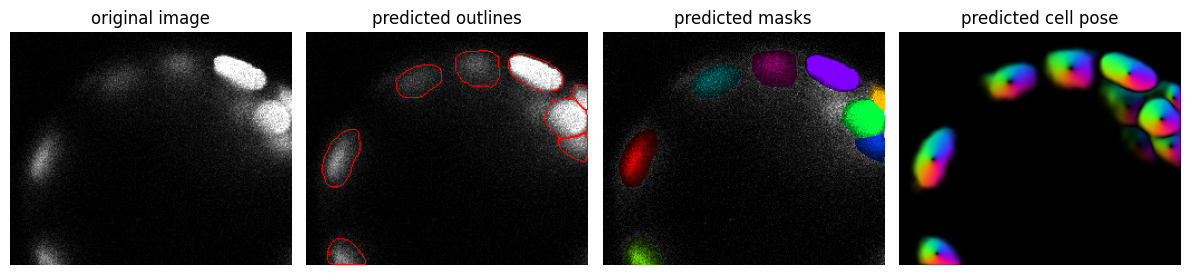

In [10]:
from cellpose import plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, data[t, 1, z, :, :], masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()

In [11]:
from cellpose import io, utils
outlines = utils.outlines_list(masks)
io.outlines_to_text(str(image_id), outlines)

In [13]:
def create_roi(img, shapes):
    # create an ROI, link it to Image
    roi = omero.model.RoiI()
    # use the omero.model.ImageI that underlies the 'image' wrapper
    roi.setImage(img._obj)
    for shape in shapes:
        roi.addShape(shape)
    return roi

In [14]:
# Convert roi into ome rois
import re
import omero
from omero.rtypes import rdouble, rint, rstring
polygons = []
with open(str(image_id) + "_cp_outlines.txt", "r") as text_file:
    for line in text_file:
        points = re.sub(r',([^,]*),', r',\1, ', line)
        polygon = omero.model.PolygonI()
        polygon.theZ = rint(z)
        polygon.theT = rint(t)
        polygon.points = rstring(points)
        polygons.append(polygon)
roi = create_roi(image, polygons)

In [16]:
# Save the ROI when using an OMERO server
if "idr" not in HOST:
    conn.getUpdateService().saveAndReturnObject(roi)

### License (BSD 2-Clause)¶

Copyright (C) 2023 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.